# Notebook description:
This notebook explores the normalized annual results for eight different sets of balance points.  We wanted to look into three questions:  
1.  Does the size of the balance point range significantly impact the normalized annual consumption results?  
2.  Do large piles at the extreme values of the balance point distributions significantly impact the normalized annual consumption results?  
3.  Does the step size between possible balance points significantly impact the normalized annual consumption results?  We did not explore this in depth, only compared a step size of 5 degrees with stepsize of 1 degree...

### The different balance point choices are:  
*Extreme values are allowed:*
- **coarse**: our original three balance points (65, 70, 75 for cooling; 55, 60, 65 for heating)
- **fine**: same ranges as the coarse balance points but with stepsize of 1 degree
- **fine wide**: one degree stepsize between 60-80 for cooling and 50-70 for heating


*Extreme values are set to the median if possible:*
- **fine median**: same as `fine` but extreme values on the edges of the balance point range are set back to the median (60F for heating, 69F for cooling) if the corresponding median-model is in the list of valid models (if not the project is thrown out because we haven't discussed fall-back options).
- **fine wide median**: same as `fine wide` but extreme values are set to the medians as in `fine median`


*Extreme values are set to the median if possible, otherwise an intercept-only model is used:*
- **coarse median intercept**: extreme values fall back to the median if that is a valid model, otherwise default to intercept-only model. Note this becomes a fixed balance point model.
- **fine median intercept**: same as `fine median` except when median is not a valid model default to intercept-only model
- **fine wide median intercept**: same as `fine wide median` except when median is not a valid model default to intercept-only model.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

COOLING_DUMMY_BALANCE_POINT = 150.
HEATING_DUMMY_BALANCE_POINT = 0.

%store -r coarse_results
%store -r fine_results
%store -r fine_results_wide
%store -r fine_results_median
%store -r fine_results_wide_median
%store -r coarse_results_median_intercept
%store -r fine_results_median_intercept
%store -r fine_results_wide_median_intercept

#### Side-by-side comparison of savings stats for all

In [2]:
results_list = [coarse_results, fine_results, fine_results_wide, fine_results_median, fine_results_wide_median,
               coarse_results_median_intercept, fine_results_median_intercept, fine_results_wide_median_intercept]
compare = []
for df in results_list:
    compare.append(df.Savings.describe())
compare_df = pd.concat(compare, axis=1)
compare_df.columns = ['coarse', 'fine', 'fine_wide', 'fine_median',
                      'fine_wide_median', 'coarse_median_intercept',
                      'fine_median_intercept', 'fine_wide_median_intercept']
compare_df

,coarse,fine,fine_wide,fine_median,fine_wide_median,coarse_median_intercept,fine_median_intercept,fine_wide_median_intercept
count,1681.000000,1681.000000,1681.000000,1290.000000,1399.000000,1681.000000,1681.000000,1681.000000
mean,365.400717,364.222501,351.041327,388.603004,390.604130,362.666951,357.700091,356.212265
std,2132.915227,2147.042436,2138.920202,2041.834399,2134.449336,2067.995734,2064.761942,2120.993015
min,-10869.283829,-10869.283829,-10828.912130,-11341.867485,-10828.912130,-11326.304601,-11341.867485,-10828.912130
25%,-425.963721,-429.956990,-448.182100,-399.125783,-384.647991,-429.956990,-450.274008,-411.912483
50%,308.011676,307.689072,299.037898,313.478322,314.425836,303.177105,290.676057,299.466956
75%,1188.339822,1211.914458,1206.880735,1211.441147,1267.765964,1157.393769,1188.644875,1210.021216
max,28736.121077,28736.121077,27806.240482,26941.764608,26941.764608,27281.106089,26941.764608,26941.764608


# Overall impression:
As long as we choose a set of rules that makes use of all the valid projects, it doesn't appear to matter very much (***for monthly data in CA***) what balance points we use, nor if we do anything with extreme values, nor the step size between them (even the `coarse median intercept` model, which uses just fixed balance points, results in normalized annual savings values and distributions similar to all the more detailed models that include all projects)...

#### `fine_results_median` includes fewer projects than `fine_results` - does dropping the missing projects from `fine_results` produce similar statistics?

Answer is yes, see below

In [23]:
spids_in_both = list(set(fine_results.index.values).intersection(set(fine_results_median.index.values)))
fine_results.Savings.ix[spids_in_both].describe()

count     1290.000000
mean       382.953082
std       2052.181470
min     -10869.283829
25%       -398.778008
50%        311.004294
75%       1213.611623
max      28736.121077
Name: Savings, dtype: float64

In [18]:
fine_results_median.Savings.describe()

count     1290.000000
mean       388.603004
std       2041.834399
min     -11341.867485
25%       -399.125783
50%        313.478322
75%       1211.441147
max      26941.764608
Name: Savings, dtype: float64

### Complete `.describe()` info for all

In [3]:
coarse_results.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,1021.000000,907.000000,1016.000000,1014.000000,1681.000000,1021.000000,907.000000,1681.000000,1016.000000,1014.000000
mean,365.400717,61.082272,68.930540,61.067913,68.525641,15.035051,0.854931,7.987585,15.176292,0.751755,3.321579
std,2132.915227,4.285073,4.022923,4.213082,4.062789,8.845034,0.948111,80.961810,8.369347,0.821284,7.698520
min,-10869.283829,55.000000,65.000000,55.000000,65.000000,0.067442,0.038840,0.076597,0.278625,0.042539,0.040571
25%,-425.963721,55.000000,65.000000,55.000000,65.000000,8.774387,0.342480,1.534900,9.413030,0.304125,1.043256
50%,308.011676,60.000000,70.000000,60.000000,65.000000,13.520255,0.588033,2.557297,13.511079,0.511054,1.691684
75%,1188.339822,65.000000,70.000000,65.000000,70.000000,19.397557,0.989277,4.670917,19.078344,0.883677,2.832706
max,28736.121077,65.000000,75.000000,65.000000,75.000000,83.241246,10.466444,2247.054022,82.262909,7.494188,119.255922


In [4]:
fine_results.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,1046.000000,920.000000,1032.000000,1024.000000,1681.000000,1046.000000,920.000000,1681.000000,1032.000000,1024.000000
mean,364.222501,60.843212,69.213043,60.777132,68.824219,15.088346,0.833661,10.172000,15.232000,0.735831,3.579790
std,2147.042436,4.049016,3.681593,3.970153,3.833836,8.848564,0.877528,85.481022,8.358722,0.757509,11.783439
min,-10869.283829,55.000000,65.000000,55.000000,65.000000,0.067442,0.038840,0.076597,0.278625,0.048242,0.040571
25%,-429.956990,57.000000,65.000000,57.000000,65.000000,8.790256,0.340819,1.610103,9.504462,0.308334,1.097443
50%,307.689072,62.000000,69.000000,61.000000,68.000000,13.519728,0.566950,2.778900,13.561446,0.505490,1.736638
75%,1211.914458,65.000000,73.000000,65.000000,72.000000,19.417264,0.978624,4.880108,19.252419,0.889682,2.994867
max,28736.121077,65.000000,75.000000,65.000000,75.000000,83.241246,9.959569,2247.054022,82.262909,6.901299,287.488211


In [5]:
fine_results_wide.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,1116.000000,984.000000,1100.000000,1073.000000,1681.000000,1116.000000,984.000000,1681.000000,1100.000000,1073.000000
mean,351.041327,61.620072,68.505081,61.392727,68.178938,14.437255,1.113050,10.446052,14.735564,0.952204,4.633510
std,2138.920202,7.017397,5.554500,6.403077,5.875071,8.858824,1.928359,82.662608,8.330583,1.326830,14.979855
min,-10828.912130,50.000000,60.000000,50.000000,60.000000,0.009368,0.033974,0.044003,0.075414,0.046634,0.033139
25%,-448.182100,56.000000,64.000000,57.000000,64.000000,8.227684,0.340789,1.401705,9.137697,0.309121,0.978460
50%,299.037898,62.000000,68.000000,62.000000,67.000000,13.009189,0.622087,2.621289,13.007807,0.538512,1.691970
75%,1206.880735,69.000000,73.000000,67.000000,73.000000,18.824259,1.145243,5.073327,18.752293,1.024694,3.303393
max,27806.240482,70.000000,80.000000,70.000000,80.000000,82.224618,35.547363,2247.054022,82.262909,16.751379,268.266065


In [6]:
fine_results_median.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1290.000000,777.000000,662.000000,741.000000,736.000000,1290.000000,777.000000,662.000000,1290.000000,741.000000,736.000000
mean,388.603004,60.142857,69.430514,59.968961,69.468750,15.384199,0.828769,6.258138,15.561421,0.694716,3.028085
std,2041.834399,1.689546,1.998601,1.807748,2.048155,8.617661,0.839007,27.530821,8.325416,0.660114,6.721194
min,-11341.867485,56.000000,66.000000,56.000000,66.000000,0.154767,0.053271,0.045679,0.307120,0.044748,0.050463
25%,-399.125783,60.000000,69.000000,60.000000,69.000000,9.117805,0.366619,1.709054,9.831933,0.319012,1.163960
50%,313.478322,60.000000,69.000000,60.000000,69.000000,14.023536,0.586295,2.769178,13.864750,0.497128,1.804343
75%,1211.441147,60.000000,70.000000,60.000000,70.000000,19.873563,0.995944,4.631842,19.737628,0.821130,2.907780
max,26941.764608,64.000000,74.000000,64.000000,74.000000,63.195621,8.463138,519.950582,82.262909,5.990777,136.121186


In [7]:
fine_results_wide_median.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1399.000000,905.000000,787.000000,882.000000,867.000000,1399.000000,905.000000,787.000000,1399.000000,882.000000,867.000000
mean,390.604130,61.030939,68.961881,60.848073,68.525952,14.876399,0.879539,9.964553,15.125540,0.803012,3.977764
std,2134.449336,4.279393,4.512473,4.384945,4.530136,8.792269,0.971502,85.747632,8.464190,1.032123,12.272780
min,-10828.912130,51.000000,61.000000,51.000000,61.000000,0.009368,0.053271,0.061033,0.075414,0.048242,0.050463
25%,-384.647991,60.000000,66.000000,58.000000,65.000000,8.732872,0.358550,1.497394,9.368909,0.327624,1.042614
50%,314.425836,60.000000,69.000000,60.000000,69.000000,13.476473,0.593704,2.737106,13.435974,0.535181,1.680339
75%,1267.765964,64.000000,72.000000,64.000000,72.000000,19.205068,0.985028,5.046574,19.227449,0.907518,3.014480
max,26941.764608,69.000000,79.000000,69.000000,79.000000,82.224618,9.969585,2247.054022,82.262909,16.751379,262.897882


In [8]:
coarse_results_median_intercept.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,818.0,695.0,775.0,772.0,1681.000000,818.000000,695.000000,1681.000000,775.000000,772.000000
mean,362.666951,60.0,70.0,60.0,70.0,16.082583,0.814440,4.456279,16.183180,0.649422,2.701134
std,2067.995734,0.0,0.0,0.0,0.0,9.174338,0.767632,5.951888,8.821258,0.556876,2.726784
min,-11326.304601,60.0,70.0,60.0,70.0,0.067442,0.053271,0.049283,0.313240,0.044748,0.053942
25%,-429.956990,60.0,70.0,60.0,70.0,9.722417,0.361820,1.706481,10.122719,0.328606,1.192118
50%,303.177105,60.0,70.0,60.0,70.0,14.481619,0.599757,2.936158,14.378631,0.502727,1.901528
75%,1157.393769,60.0,70.0,60.0,70.0,20.658645,0.982500,5.153633,20.228089,0.793602,3.115487
max,27281.106089,60.0,70.0,60.0,70.0,99.060375,8.463138,77.322412,82.262909,5.751371,29.914135


In [9]:
fine_results_median_intercept.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,886.000000,751.000000,831.000000,825.000000,1681.000000,886.000000,751.000000,1681.000000,831.000000,825.000000
mean,357.700091,60.120767,69.404794,59.991576,69.459394,15.816957,0.819347,6.910539,15.991196,0.686611,3.095578
std,2064.761942,1.686127,2.015587,1.811922,2.023793,9.045297,0.814897,33.270689,8.758333,0.642912,6.619871
min,-11341.867485,56.000000,66.000000,56.000000,66.000000,0.067442,0.053271,0.045679,0.307120,0.044748,0.050463
25%,-450.274008,60.000000,68.000000,60.000000,69.000000,9.456509,0.363735,1.672815,9.974707,0.327271,1.164435
50%,290.676057,60.000000,69.000000,60.000000,69.000000,14.292702,0.586243,2.787916,14.200962,0.498723,1.845188
75%,1188.644875,60.000000,70.000000,60.000000,70.000000,20.381824,0.982349,4.844945,19.981371,0.801782,2.992887
max,26941.764608,64.000000,74.000000,64.000000,74.000000,99.060375,8.463138,576.308283,82.262909,5.990777,136.121186


In [10]:
fine_results_wide_median_intercept.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp,pre intercept,pre h coeff,pre c coeff,post intercept,post h coeff,post c coeff
count,1681.000000,988.000000,863.000000,966.000000,944.000000,1681.000000,988.000000,863.000000,1681.000000,966.000000,944.000000
mean,356.212265,61.026316,68.994206,60.791925,68.461864,15.169858,0.860481,9.697304,15.357574,0.807016,3.924116
std,2120.993015,4.274440,4.483143,4.349877,4.529230,9.015349,0.945928,82.081147,8.552615,1.057603,11.838262
min,-10828.912130,51.000000,61.000000,51.000000,61.000000,0.009368,0.053271,0.044003,0.075414,0.048242,0.050463
25%,-411.912483,60.000000,66.000000,58.000000,65.000000,8.865921,0.344811,1.502054,9.544765,0.327624,1.038478
50%,299.466956,60.000000,69.000000,60.000000,69.000000,13.689340,0.580217,2.737106,13.673400,0.528555,1.680682
75%,1210.021216,64.000000,72.000000,64.000000,71.000000,19.502567,0.978391,5.046574,19.564729,0.896246,3.014479
max,26941.764608,69.000000,79.000000,69.000000,79.000000,82.224618,9.969585,2247.054022,82.262909,16.751379,262.897882


### Look at the balance point distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1105ec5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d110908>]], dtype=object)

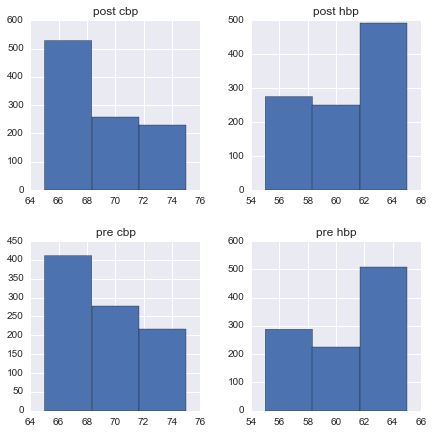

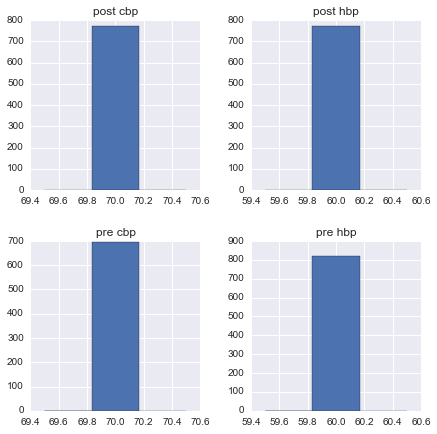

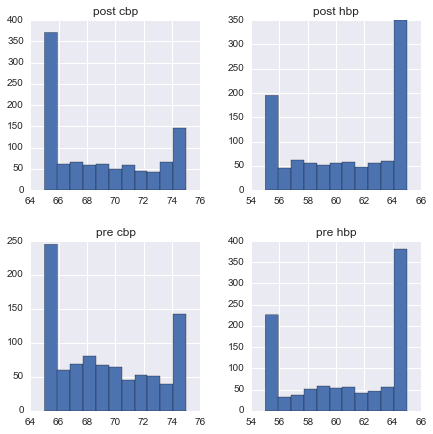

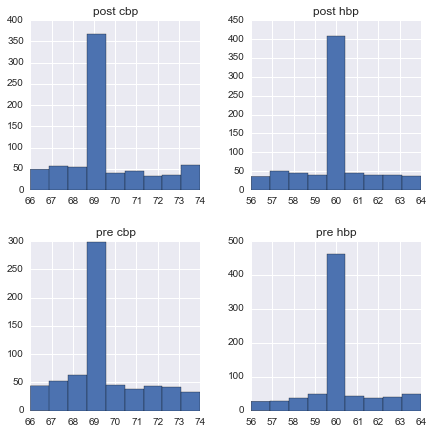

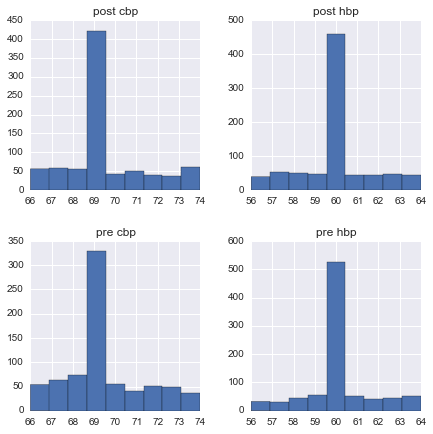

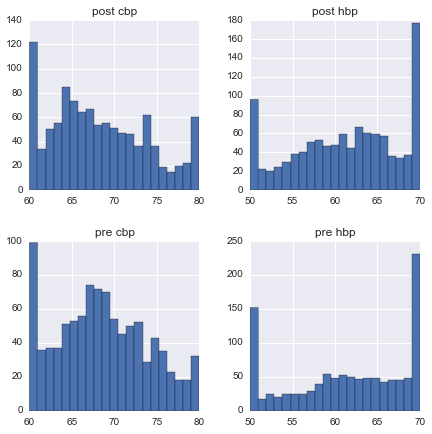

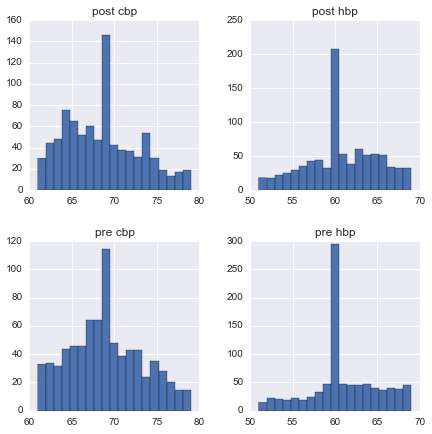

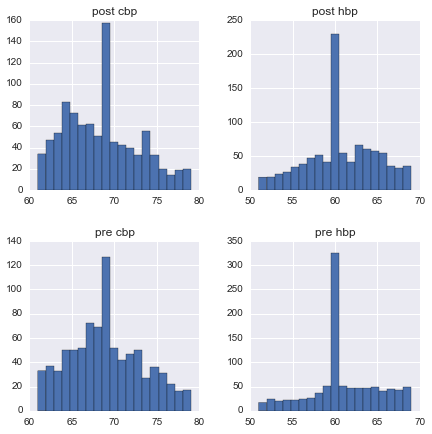

In [21]:
def remove_dummy_balance_points(df):
    '''Change the dummy heating and cooling balance points to np.nan
    '''
    return df.replace(str(HEATING_DUMMY_BALANCE_POINT), np.nan).replace(str(COOLING_DUMMY_BALANCE_POINT), np.nan)

coarse_results_valid = remove_dummy_balance_points(coarse_results)
fine_results_valid = remove_dummy_balance_points(fine_results)
fine_results_wide_valid = remove_dummy_balance_points(fine_results_wide)
fine_results_median_valid = remove_dummy_balance_points(fine_results_median)
fine_results_wide_median_valid = remove_dummy_balance_points(fine_results_wide_median)
coarse_results_median_intercept_valid = remove_dummy_balance_points(coarse_results_median_intercept)
fine_results_median_intercept_valid = remove_dummy_balance_points(fine_results_median_intercept)
fine_results_wide_median_intercept_valid = remove_dummy_balance_points(fine_results_wide_median_intercept)

coarse_results_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=3, figsize=(7, 7))
coarse_results_median_intercept_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=3, figsize=(7, 7))

fine_results_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=11, figsize=(7, 7))
fine_results_median_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=9, figsize=(7, 7))
fine_results_median_intercept_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=9, figsize=(7, 7))

fine_results_wide_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=21, figsize=(7, 7))
fine_results_wide_median_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=19, figsize=(7, 7))
fine_results_wide_median_intercept_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=19, figsize=(7, 7))

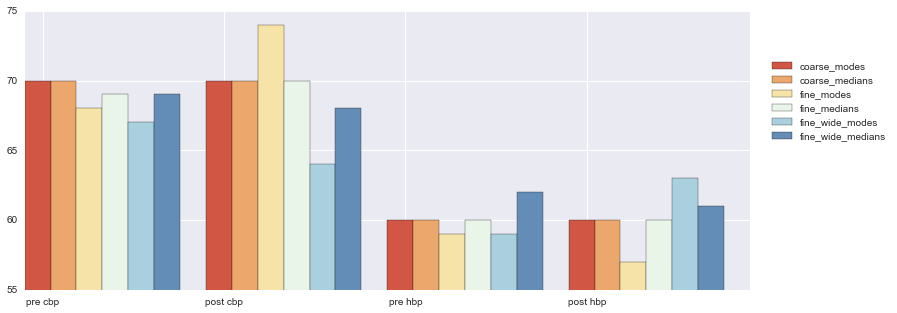

In [12]:
def get_mode_of_column(df, col_name):
    '''Get the mode of a column excluding the extreme values on the ends of the distribution.
    If there are multiple values with the same count, the first is returned.
    
    @param df: a pandas dataframe
    @param col_name: str, the name of the column to get the mode for
    @return: list with two arrays of single values; first the value of the mode, second the count of that value
    '''
    min_extreme = df[col_name].min()
    max_extreme = df[col_name].max()
    mode = stats.mode(df.ix[(df[col_name] != min_extreme) & (df[col_name] != max_extreme), col_name])
    return mode


def get_mode_for_all_balancepoints(df):
    '''Get the mode for all the balance point columns in a dataframe
    
    @param df: a pandas dataframe with columns for pre and post cbp/hbp
    @return: an array of the modes for [pre cbp, post cbp, pre hbp, post hbp]
    '''
    pre_cbp = get_mode_of_column(df, 'pre cbp')
    post_cbp = get_mode_of_column(df, 'post cbp')
    pre_hbp = get_mode_of_column(df, 'pre hbp')
    post_hbp = get_mode_of_column(df, 'post hbp')
    
    return np.concatenate([pre_cbp[0], post_cbp[0], pre_hbp[0], post_hbp[0]])


def get_median_of_column(df, col_name):
    '''Get the median of a column excluding the extreme values at the ends of the distribution.
    '''
    min_extreme = df[col_name].min()
    max_extreme = df[col_name].max()
    median = np.nanmedian(df.ix[(df[col_name] != min_extreme) & (df[col_name] != max_extreme), col_name])
    return median


def get_median_for_all_balancepoints(df):
    '''Get the median for all the balance point columns in a dataframe
    
    @param df: a pandas dataframe with columns for pre and post cbp/hbp
    @return: an array of the medians for [pre cbp, post cbp, pre hbp, post hbp]
    '''
    pre_cbp = get_median_of_column(df, 'pre cbp')
    post_cbp = get_median_of_column(df, 'post cbp')
    pre_hbp = get_median_of_column(df, 'pre hbp')
    post_hbp = get_median_of_column(df, 'post hbp')
    return [pre_cbp, post_cbp, pre_hbp, post_hbp]
    

coarse_modes = get_mode_for_all_balancepoints(coarse_results_valid)
fine_modes = get_mode_for_all_balancepoints(fine_results_valid)
fine_wide_modes = get_mode_for_all_balancepoints(fine_results_wide_valid)
coarse_medians = get_median_for_all_balancepoints(coarse_results_valid)
fine_medians = get_median_for_all_balancepoints(fine_results_valid)
fine_wide_medians = get_median_for_all_balancepoints(fine_results_wide_valid)

plt.figure(figsize=(13, 5))
palette = sns.color_palette(palette='RdYlBu', n_colors=6, desat=0.8)
bar_width = 1 / 7.
right = [coarse_modes, coarse_medians, fine_modes, fine_medians, fine_wide_modes, fine_wide_medians]
labels = ['coarse_modes', 'coarse_medians', 'fine_modes', 'fine_medians', 'fine_wide_modes', 'fine_wide_medians']
for x in range(0, 6):
    left = [0 + x * bar_width, 1 + x * bar_width, 2 + x * bar_width, 3 + x * bar_width]
    plt.bar(left, right[x], width=bar_width, color=palette[x], label=labels[x])
plt.axis([0, 4, 55, 75])
plt.xticks([0.1, 1.1, 2.1, 3.1], ['pre cbp', 'post cbp', 'pre hbp', 'post hbp'])
plt.legend(loc=1, bbox_to_anchor=(1.2, 0.85))